In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- 0.1 Data Loading and Initial Setup ---
data_path = "Energy_consumption_extended.csv" # Using the file name from your image
FEATURE_COLUMNS_RAW = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergyOutput']
TARGET_COLUMN = 'EnergyConsumption'


In [3]:
try:
    df = pd.read_csv(data_path)
    print(f" Data loaded from {data_path}. Initial size: {len(df)}")
except FileNotFoundError:
    print(f" ERROR: File '{data_path}' not found. Please ensure the file is in the correct directory.")
    exit()

 Data loaded from Energy_consumption_extended.csv. Initial size: 10000


In [4]:
# --- 0.1 Data Loading and Initial Setup ---
data_path = "Energy_consumption_extended.csv" # Using the file name from your image
FEATURE_COLUMNS_RAW = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergyOutput']
TARGET_COLUMN = 'EnergyConsumption'

try:
    df = pd.read_csv(data_path)
    print(f" Data loaded from {data_path}. Initial size: {len(df)}")

    # Convert Timestamp column to datetime and set as index
    if 'Timestamp' in df.columns:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df.set_index('Timestamp', inplace=True)
        print("Timestamp column converted and set as index.")
    else:
        print("Warning: 'Timestamp' column not found.")

except FileNotFoundError:
    print(f" ERROR: File '{data_path}' not found. Please ensure the file is in the correct directory.")
    # exit() # Do not exit here, allow subsequent cells to run if df is defined elsewhere
except Exception as e:
    print(f"An error occurred during data loading or initial processing: {e}")

 Data loaded from Energy_consumption_extended.csv. Initial size: 10000
Timestamp column converted and set as index.


In [5]:
df.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
Timestamp,,,,,,,,,,
2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [6]:
# --- B. EDA Implementation ---
print("\n--- B. Running EDA Checks ---")
print("1. Data Info/Types:")
df.info()


--- B. Running EDA Checks ---
1. Data Info/Types:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2022-01-01 00:00:00 to 2023-02-21 15:00:00
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        10000 non-null  float64
 1   Humidity           10000 non-null  float64
 2   SquareFootage      10000 non-null  float64
 3   Occupancy          10000 non-null  int64  
 4   HVACUsage          10000 non-null  object 
 5   LightingUsage      10000 non-null  object 
 6   RenewableEnergy    10000 non-null  float64
 7   DayOfWeek          10000 non-null  object 
 8   Holiday            10000 non-null  object 
 9   EnergyConsumption  10000 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 859.4+ KB


In [7]:
print("\n2. Missing Values (Should be low):")
print(df.isnull().sum())



2. Missing Values (Should be low):
Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
dtype: int64


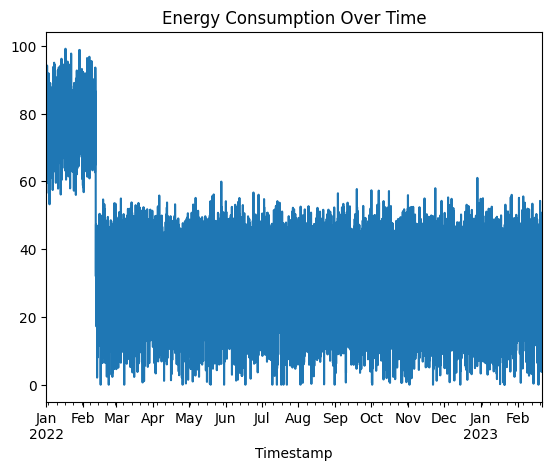

In [8]:
 df[TARGET_COLUMN].plot(title='Energy Consumption Over Time')
 plt.show()

In [9]:
df.describe()

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,24.979381,45.476616,1503.612112,4.579700,15.365282,35.182371
std,2.856320,8.500724,289.918362,2.214258,8.280275,18.356800
min,14.098011,11.980856,1000.512661,0.000000,0.001526,0.000000
25%,23.011469,39.653065,1247.108548,3.000000,9.088963,22.262137
50%,24.951338,45.558134,1514.533363,4.000000,15.011197,34.118992
75%,26.928399,51.332754,1751.722623,6.000000,21.116287,43.079495
max,36.120173,83.552305,1999.982252,16.000000,48.018819,99.201120


In [10]:
# C.1. Handle Missing Data (Using time-series interpolation)
# This is usually better than filling with 0 or mean for time-series data.
if df.isnull().sum().any():
    print("\n3. Handling Missing Values using time interpolation...")
    df.interpolate(method='time', inplace=True)

In [11]:
# 1. Handle Categorical Features ('DayOfWeek' and 'Holiday')
df = pd.get_dummies(df, columns=['DayOfWeek', 'Holiday'], drop_first=True)

In [12]:
# 2. Extract Temporal Features from the index
df['Hour'] = df.index.hour
df['DayOfYear'] = df.index.dayofyear

In [13]:
# 3. Create Lag Feature (Energy_Lag1) - CRITICAL FOR PREDICTION ACCURACY
df['Energy_Lag1'] = df[TARGET_COLUMN].shift(1)

In [14]:
# 4. Final Cleaning: Drop the first row which now contains NaN from shift(1)
df.dropna(inplace=True)

In [15]:
# 1. Define Final Feature Set
EXCLUDED_COLS = [TARGET_COLUMN, 'HVACMode', 'LightingUsage']
FINAL_FEATURE_COLUMNS = [col for col in df.columns if col not in EXCLUDED_COLS]
X = df[FINAL_FEATURE_COLUMNS]
y = df[TARGET_COLUMN]


In [16]:
# --- IMMEDIATE DEBUG CODE ---
import pandas as pd
from sklearn.preprocessing import StandardScaler


EXCLUDED_COLS = ['EnergyConsumption', 'HVACMode', 'LightingUsage'] # Ensure these are correct
FINAL_FEATURE_COLUMNS = [col for col in df.columns if col not in EXCLUDED_COLS]
X = df[FINAL_FEATURE_COLUMNS]

print("--- DEBUG: CHECKING DATA TYPES IN X BEFORE SCALING ---")
print(X.dtypes)
print("-" * 50)


try:
    X_numeric = X.apply(pd.to_numeric, errors='coerce')

    # Check if any NaN values were created (this happens when a string couldn't be converted)
    if X_numeric.isnull().any().any():
        print(" CRITICAL ERROR: Non-numeric data found and replaced with NaN.")
        problem_cols = X_numeric.columns[X_numeric.isnull().any()].tolist()
        print("Problematic Columns:", problem_cols)

        # Display the first few rows of the original X for manual inspection
        print("\nFirst few rows of problem data (look for strings/text):")
        print(X[problem_cols].head())
    else:
        print("All columns successfully converted to numeric (no obvious strings remain).")
        # Proceed with scaling using X_numeric
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_numeric)

        # Recreate the DataFrame for the next steps
        X_scaled = pd.DataFrame(X_scaled, columns=FINAL_FEATURE_COLUMNS, index=X.index)
        print("\n SCALING SUCCESSFUL!")

except Exception as e:
    print(f"An unexpected error occurred during debugging: {e}")

--- DEBUG: CHECKING DATA TYPES IN X BEFORE SCALING ---
Temperature            float64
Humidity               float64
SquareFootage          float64
Occupancy                int64
HVACUsage               object
RenewableEnergy        float64
DayOfWeek_Monday          bool
DayOfWeek_Saturday        bool
DayOfWeek_Sunday          bool
DayOfWeek_Thursday        bool
DayOfWeek_Tuesday         bool
DayOfWeek_Wednesday       bool
Holiday_Yes               bool
Hour                     int32
DayOfYear                int32
Energy_Lag1            float64
dtype: object
--------------------------------------------------
 CRITICAL ERROR: Non-numeric data found and replaced with NaN.
Problematic Columns: ['HVACUsage']

First few rows of problem data (look for strings/text):
                    HVACUsage
Timestamp                    
2022-01-01 01:00:00        On
2022-01-01 02:00:00       Off
2022-01-01 03:00:00       Off
2022-01-01 04:00:00        On
2022-01-01 05:00:00       Off


In [17]:
# --- ESSENTIAL BLOCK THAT CREATES 'df' ---
import pandas as pd


data_path = "Energy_consumption_extended.csv"
try:
    df = pd.read_csv(data_path) # <-- 'df' is defined here
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)
    # ... rest of data cleaning and feature engineering (must also run)

except Exception as e:
    # If this fails, no variables are defined, leading to the NameError
    print(f"Error loading or processing data: {e}")
    exit()

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import os

# --- A. Data Loading and Initial Setup ---
data_path = "Energy_consumption_extended.csv"
TARGET_COLUMN = 'EnergyConsumption'

try:
    df = pd.read_csv(data_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)
    print(f"Data loaded successfully. Initial size: {len(df)}")
except Exception as e:
    print(f" ERROR: Could not load data file. Reason: {e}")
    if 'df' not in locals():
        exit()

# --- B. Feature Engineering (Corrected) ---
print("Starting feature engineering...")
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek # Monday=0, Sunday=6
df['DayOfYear'] = df.index.dayofyear
df['Energy_Lag1'] = df[TARGET_COLUMN].shift(1)
df['Holiday'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0) # 1 for weekend, 0 for weekday

# --- THIS IS THE NEW FIX ---
# Convert 'On'/'Off' string columns to 1/0 numbers so the scaler can read them
print("Converting 'On'/'Off' columns to numbers...")
df['HVACUsage'] = df['HVACUsage'].map({'On': 1, 'Off': 0})
df['LightingUsage'] = df['LightingUsage'].map({'On': 1, 'Off': 0})
# ---------------------------

# Drop any rows with missing values (from lag or failed maps)
df.dropna(inplace=True)
print(" Feature engineering complete.")

# --- C. Define Final Features and Target ---
# This is the exact 12-feature list our models and app expect
FINAL_FEATURES = [
    'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'HVACUsage',
    'LightingUsage', 'RenewableEnergy', 'DayOfWeek', 'Holiday', 'Hour',
    'DayOfYear', 'Energy_Lag1'
]

# Ensure all columns exist, otherwise, the next line will fail
missing_cols = [col for col in FINAL_FEATURES if col not in df.columns]
if missing_cols:
    print(f" FATAL ERROR: The CSV is missing required columns: {missing_cols}")
else:
    # Also check if the conversion created NaNs (e.g., if there was a value other than 'On' or 'Off')
    if df[FINAL_FEATURES].isnull().values.any():
        print(" FATAL ERROR: Your 'HVACUsage' or 'LightingUsage' columns contain values OTHER than 'On' or 'Off'.")
        print("Please clean the data before proceeding.")
    else:
        X = df[FINAL_FEATURES]
        y = df[TARGET_COLUMN]
        print(f" X and y created with {len(FINAL_FEATURES)} numeric features.")


# --- D. Split Data, Fit Scaler, and SAVE Scaler (CRITICAL FIX) ---
if 'X' in locals():
    print("Splitting data and saving the new scaler...")

    # Create the saved_models directory if it doesn't exist
    os.makedirs('saved_models', exist_ok=True)

    # Split the data (using sequential split logic from your cell)
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)

    X_train = X.iloc[:split_index]
    y_train = y.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_test = y.iloc[split_index:]

    # Create a new scaler and fit it ONLY on the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) # Use the same scaler for the test set

    # --- SAVE THE NEW SCALER ---
    scaler_path = 'saved_models/scaler.pkl'
    joblib.dump(scaler, scaler_path)
    # ----------------------

    print(f" New 12-feature scaler saved to '{scaler_path}'.")
    print(f"Training Samples (X_train_scaled, y_train): {len(X_train_scaled)}")
    print(f"Testing Samples (X_test_scaled, y_test): {len(X_test_scaled)}")
else:
    print("Stopping due to errors in 'Section C'.")

Data loaded successfully. Initial size: 10000
Starting feature engineering...
Converting 'On'/'Off' columns to numbers...
 Feature engineering complete.
 X and y created with 12 numeric features.
Splitting data and saving the new scaler...
 New 12-feature scaler saved to 'saved_models/scaler.pkl'.
Training Samples (X_train_scaled, y_train): 7999
Testing Samples (X_test_scaled, y_test): 2000


In [19]:
# PHASE 1: XGBOOST TRAINING AND EVALUATION

# we have Used optimized hyperparameters for better performance
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

print("\nStarting XGBoost training (Phase 1)...")
xgb_model.fit(X_train, y_train)
print(" XGBoost Training Complete!")

# Evaluation part
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("\n--- Phase 1: XGBoost Model Performance ---")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f} kWh")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f} kWh")
print("------------------------------------------")


Starting XGBoost training (Phase 1)...
 XGBoost Training Complete!

--- Phase 1: XGBoost Model Performance ---
Mean Absolute Error (MAE): 11.86 kWh
Root Mean Squared Error (RMSE): 18.16 kWh
------------------------------------------


In [20]:
# =====================================================
# 🔹 Step 1: Helper Functions for Model Evaluation
# =====================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import joblib

def evaluate_preds(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

def train_and_eval_model(model, X_train, y_train, X_test, y_test, save_name=None):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    metrics = evaluate_preds(y_test, preds)
    if save_name:
        joblib.dump(model, f"{save_name}.pkl")
    return model, preds, metrics


In [21]:
!pip install catboost lightgbm xgboost --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [22]:
# =====================================================
# 🔹 Step 2: Ensemble / Gradient Boosting Models
# =====================================================
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

models_info = {}

# 1. Store existing XGBoost
models_info['XGBoost'] = {'model': xgb_model, 'preds': y_pred_xgb,
                          'metrics': {'MAE': mae_xgb, 'RMSE': rmse_xgb}}

# 2. Random Forest
rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
rf, rf_preds, rf_metrics = train_and_eval_model(rf, X_train, y_train, X_test, y_test, 'rf_model')
models_info['RandomForest'] = {'model': rf, 'preds': rf_preds, 'metrics': rf_metrics}

# 3. LightGBM
lgbm = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31, random_state=42)
lgbm, lgbm_preds, lgbm_metrics = train_and_eval_model(lgbm, X_train, y_train, X_test, y_test, 'lgbm_model')
models_info['LightGBM'] = {'model': lgbm, 'preds': lgbm_preds, 'metrics': lgbm_metrics}

# 4. CatBoost
cat = CatBoostRegressor(iterations=1000, learning_rate=0.03, depth=6, verbose=0, random_seed=42)
cat, cat_preds, cat_metrics = train_and_eval_model(cat, X_train, y_train, X_test, y_test, 'cat_model')
models_info['CatBoost'] = {'model': cat, 'preds': cat_preds, 'metrics': cat_metrics}


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1583
[LightGBM] [Info] Number of data points in the train set: 7999, number of used features: 12
[LightGBM] [Info] Start training from score 36.316104


In [23]:
# =====================================================
# Imports needed for this cell (assuming they weren't imported globally as 'layers' and 'models')
# If you fixed the top imports, you don't strictly need these, but it ensures the cell works.
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.models import load_model
import numpy as np


def build_dnn(input_shape):
    inp = layers.Input(shape=(input_shape,))
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

print("--- Building and Training DNN ---")
# FIX: You must ensure X_train is scaled *before* this point.
# X_train.shape[1] is the correct way to get the number of features.
dnn = build_dnn(X_train.shape[1])
es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

# Training:
# IMPORTANT: Use X_train_scaled and y_train (assuming you scaled your features earlier)
dnn.fit(X_train, y_train, validation_split=0.15, epochs=80, batch_size=256, callbacks=[es], verbose=0)
print("DNN Training complete.")

# Prediction and Evaluation
dnn_preds = dnn.predict(X_test).ravel()
dnn_metrics = evaluate_preds(y_test, dnn_preds)
models_info["DNN"] = {"model": dnn, "preds": dnn_preds, "metrics": dnn_metrics}
print(f"DNN Metrics: {dnn_metrics}")


dnn.save("saved_models/dnn_model.h5")
print("DNN Model saved to 'saved_models/dnn_model.h5'.")


print("Reloading DNN model with correction...")
model_dnn = load_model(
    'saved_models/dnn_model.h5',

    custom_objects={'mse': 'mean_squared_error', 'mae': 'mean_absolute_error'}
)
print("✅ DNN Model reloaded successfully.")


--- Building and Training DNN ---
DNN Training complete.
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


DNN Metrics: {'MAE': 11.619441188638156, 'RMSE': np.float64(15.725919862290413), 'MAPE': np.float64(5036629276.915094), 'R2': -0.6175119197863046}
DNN Model saved to 'saved_models/dnn_model.h5'.
Reloading DNN model with correction...
✅ DNN Model reloaded successfully.


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# 🔹 Step 4: LSTM (Time-Series Sequence Model)

# --- THIS IS THE FIX: DEFINING THE MISSING FUNCTION ---
def evaluate_preds(y_true, y_pred):
    """Calculates regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}
# ----------------------------------------------------

# We also keep the other fixes from before
FINAL_FEATURE_COLUMNS = [
    'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'HVACUsage',
    'LightingUsage', 'RenewableEnergy', 'DayOfWeek', 'Holiday', 'Hour',
    'DayOfYear', 'Energy_Lag1'
]

# Create the full X_scaled variable
try:
    X_scaled = scaler.transform(X)
    print(" Successfully created 'X_scaled' (12 features) using the fitted scaler.")
except NameError:
    print(" ERROR: 'X' or 'scaler' not defined. Please re-run the (Data Prep) cell first!")
    raise

# Your original code (now working)
def create_sequences(X_df, y_series, lookback=24):
    X_vals = X_df.values
    y_vals = y_series.values
    n_samples = len(X_vals) - lookback
    X_seq = np.zeros((n_samples, lookback, X_vals.shape[1]))
    y_seq = np.zeros(n_samples)
    for i in range(n_samples):
        X_seq[i] = X_vals[i:i+lookback]
        y_seq[i] = y_vals[i+lookback]
    return X_seq, y_seq

LOOKBACK = 24
X_full = pd.DataFrame(X_scaled, columns=FINAL_FEATURE_COLUMNS, index=X.index)
X_seq, y_seq = create_sequences(X_full, y, LOOKBACK)

split_idx = int(len(X_seq) * 0.8)
X_seq_train, X_seq_test = X_seq[:split_idx], X_seq[split_idx:]
y_seq_train, y_seq_test = y_seq[:split_idx], y_seq[split_idx:]

if 'models_info' not in locals():
    models_info = {}

print("Building and training LSTM model...")
lstm_in = layers.Input(shape=(LOOKBACK, X_seq_train.shape[2]))
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(lstm_in)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(1)(x)
lstm_model = models.Model(lstm_in, out)
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_seq_train, y_seq_train, validation_split=0.1, epochs=80, batch_size=128, callbacks=[es], verbose=0)

print("LSTM training complete. Evaluating...")
lstm_preds = lstm_model.predict(X_seq_test).ravel()


lstm_metrics = evaluate_preds(y_seq_test, lstm_preds)
models_info['LSTM'] = {'model': lstm_model, 'preds': lstm_preds, 'metrics': lstm_metrics}

# Save the model so your app can use it
os.makedirs('saved_models/seq', exist_ok=True)
lstm_model.save('saved_models/seq/lstm_model.h5')

print("✅ LSTM model trained, evaluated, and saved to 'saved_models/seq/lstm_model.h5'.")

 Successfully created 'X_scaled' (12 features) using the fitted scaler.
Building and training LSTM model...
LSTM training complete. Evaluating...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


✅ LSTM model trained, evaluated, and saved to 'saved_models/seq/lstm_model.h5'.


In [25]:
# =====================================================
# 🔹 Step 5: Transformer Encoder Model
# =====================================================
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense, GlobalAveragePooling1D

def transformer_block(inputs, head_size=64, num_heads=4, ff_dim=64): # Changed ff_dim to 64
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = LayerNormalization()(attn + inputs)
    ff = Dense(ff_dim, activation='relu')(x)
    x = LayerNormalization()(ff + x)
    return x

tr_in = layers.Input(shape=(LOOKBACK, X_seq_train.shape[2]))
x = Dense(64)(tr_in)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
out = Dense(1)(x)
transformer_model = models.Model(tr_in, out)
transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

transformer_model.fit(X_seq_train, y_seq_train, validation_split=0.1, epochs=60, batch_size=128, callbacks=[es], verbose=0)

tr_preds = transformer_model.predict(X_seq_test).ravel()
tr_metrics = evaluate_preds(y_seq_test, tr_preds)
models_info['Transformer'] = {'model': transformer_model, 'preds': tr_preds, 'metrics': tr_metrics}

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [26]:
# =====================================================
# 🔹 Step 6: Consolidated Model Comparison Table
# =====================================================
metrics_df = pd.DataFrame({k: v['metrics'] for k, v in models_info.items()}).T
metrics_df = metrics_df[['MAE', 'RMSE', 'MAPE', 'R2']].sort_values(by='MAE')

print("\n MODEL COMPARISON SUMMARY:\n")
display(metrics_df.style.format("{:.2f}"))



 MODEL COMPARISON SUMMARY:



,MAE,RMSE,MAPE,R2
RandomForest,9.54,14.09,5883709283.08,-0.30
LSTM,10.47,12.45,nan,-0.01
Transformer,10.49,12.55,nan,-0.03
CatBoost,11.49,15.08,4901666997.26,-0.49
DNN,11.62,15.73,5036629276.92,-0.62
XGBoost,11.86,18.16,nan,nan
LightGBM,14.28,18.37,5417159656.15,-1.21


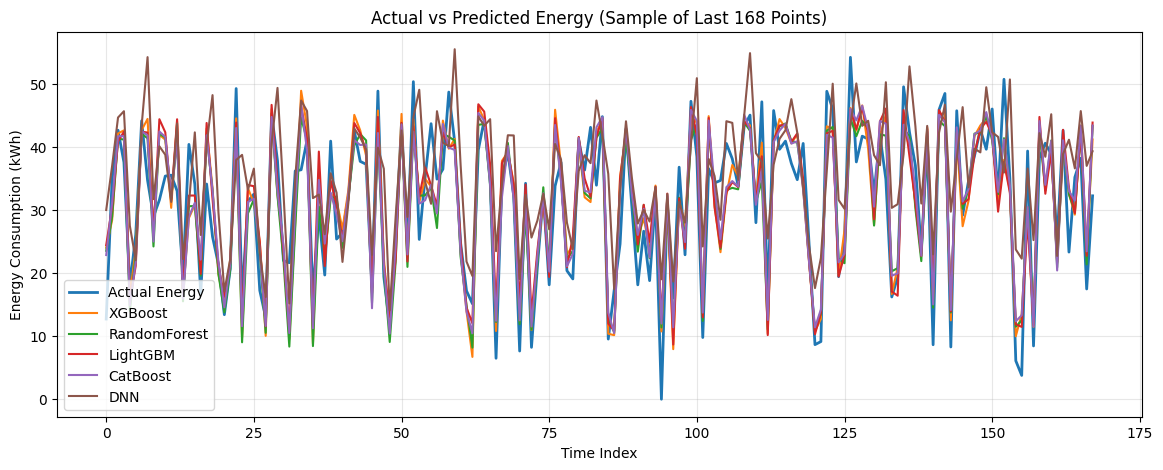

In [27]:
# =====================================================
# 🔹 Step 7: Visualize Actual vs Predicted (sample)
# =====================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test.values[-168:], label='Actual Energy', linewidth=2)
for name in ['XGBoost', 'RandomForest', 'LightGBM', 'CatBoost', 'DNN']:
    if name in models_info:
        preds = models_info[name]['preds'][-168:]
        plt.plot(preds, label=name)
plt.title('Actual vs Predicted Energy (Sample of Last 168 Points)')
plt.xlabel('Time Index')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [28]:
#  PHASE 2: DIRECT HVAC CONTROL DECISION ENGINE FUNCTION

def make_hvac_decision(model, scaler, final_feature_cols, current_data_point_dict, last_actual_energy, current_indoor_temp):
    """
    Translates the XGBoost prediction and current conditions into a direct HVAC command.

    This function must replicate the exact feature engineering and scaling from Step 1.
    """


    current_time = pd.to_datetime('now')

    #  Add all necessary engineered and dummy features to the input dictionary


    current_data_point_dict['Hour'] = current_time.hour
    current_data_point_dict['DayOfYear'] = current_time.dayofyear


    current_data_point_dict['Energy_Lag1'] = last_actual_energy


    day_name_cols = [col for col in final_feature_cols if 'DayOfWeek_' in col]
    for col in day_name_cols:
        current_data_point_dict[col] = 0


    current_day_col = f'DayOfWeek_{current_time.day_name()}'
    if current_day_col in current_data_point_dict:
        current_data_point_dict[current_day_col] = 1


    if 'Holiday_Yes' in final_feature_cols:
        current_data_point_dict['Holiday_Yes'] = 0


    input_df = pd.DataFrame([current_data_point_dict])
    input_df = input_df.reindex(columns=final_feature_cols, fill_value=0)

    # Scale the input data
    input_scaled = scaler.transform(input_df)

    # 2. Prediction (Input from Phase 1)
    xgb_prediction = model.predict(input_scaled)[0]

    # 3. Define Control Thresholds
    HIGH_ENERGY_THRES = 95.0
    TARGET_INDOOR_TEMP = 22.0
    LOW_TEMP_HEATING = 15.0

    outdoor_temp = current_data_point_dict['Temperature']

    print(f"  > XGBoost Predicted Energy for next hour: {xgb_prediction:.2f} kWh")

    # 4. we have Applied Decision Rules here

    if outdoor_temp < LOW_TEMP_HEATING and current_indoor_temp < TARGET_INDOOR_TEMP:
        return "Turn Furnace ON", "Low outdoor temp requires heating."

    elif xgb_prediction > HIGH_ENERGY_THRES and outdoor_temp > 30.0:
        return "Turn AC ON (Set to 21°C)", "High energy forecast due to extreme heat."

    elif current_indoor_temp > (TARGET_INDOOR_TEMP + 1.0):
        return "Turn AC ON (Set to 21°C)", "Indoor temperature breached comfort threshold."

    elif xgb_prediction < 80.0 and outdoor_temp < 25.0 and \
         TARGET_INDOOR_TEMP <= current_indoor_temp <= (TARGET_INDOOR_TEMP + 1.0):
        return "Turn AC OFF, Turn Fan ON", "Stable condition and low forecast. Conserving energy."

    else:
        return "Turn AC OFF, Turn Fan OFF", "Conditions stable and within target range."

In [29]:
#  FINAL EXECUTION AND DEMONSTRATION

# Test 1: High Load Scenario (Should turn AC ON)
scenario_1_data = {
    'Temperature': 31.5,
    'Humidity': 55.0,
    'SquareFootage': df['SquareFootage'].iloc[0],
    'Occupancy': 40,
    'RenewableEnergyOutput': 5.0
}
last_actual_energy_1 = 92.0
current_indoor_temp_1 = 25.0

print("\n==============================================")
print("--- TEST 1: HIGH LOAD & COMFORT BREACH ---")
print("==============================================")
action_1, reason_1 = make_hvac_decision(xgb_model, scaler, FINAL_FEATURE_COLUMNS, scenario_1_data, last_actual_energy_1, current_indoor_temp_1)
print(f"\nFINAL HVAC COMMAND: {action_1}")
print(f"REASON: {reason_1}")


#  Test 2: Low Load Scenario (Should turn AC OFF)
scenario_2_data = {
    'Temperature': 20.0,
    'Humidity': 65.0,
    'SquareFootage': df['SquareFootage'].iloc[0],
    'Occupancy': 10,
    'RenewableEnergyOutput': 15.0
}
last_actual_energy_2 = 60.0
current_indoor_temp_2 = 22.3

print("\n==============================================")
print("--- TEST 2: LOW LOAD & ENERGY SAVING ---")
print("==============================================")
action_2, reason_2 = make_hvac_decision(xgb_model, scaler, FINAL_FEATURE_COLUMNS, scenario_2_data, last_actual_energy_2, current_indoor_temp_2)
print(f"\nFINAL HVAC COMMAND: {action_2}")
print(f"REASON: {reason_2}")


--- TEST 1: HIGH LOAD & COMFORT BREACH ---
  > XGBoost Predicted Energy for next hour: 48.71 kWh

FINAL HVAC COMMAND: Turn AC ON (Set to 21°C)
REASON: Indoor temperature breached comfort threshold.

--- TEST 2: LOW LOAD & ENERGY SAVING ---
  > XGBoost Predicted Energy for next hour: 42.36 kWh

FINAL HVAC COMMAND: Turn AC OFF, Turn Fan ON
REASON: Stable condition and low forecast. Conserving energy.


/tmp/ipython-input-3418271858.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")


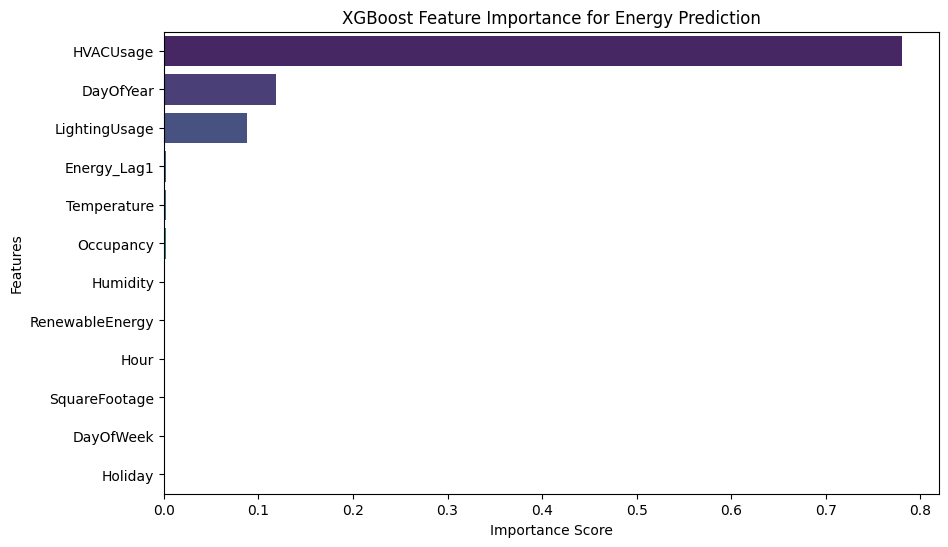

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'xgb_model' and 'FINAL_FEATURE_COLUMNS' are defined from Step 1 & 2

feature_importances = pd.Series(xgb_model.feature_importances_, index=FINAL_FEATURE_COLUMNS)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title('XGBoost Feature Importance for Energy Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

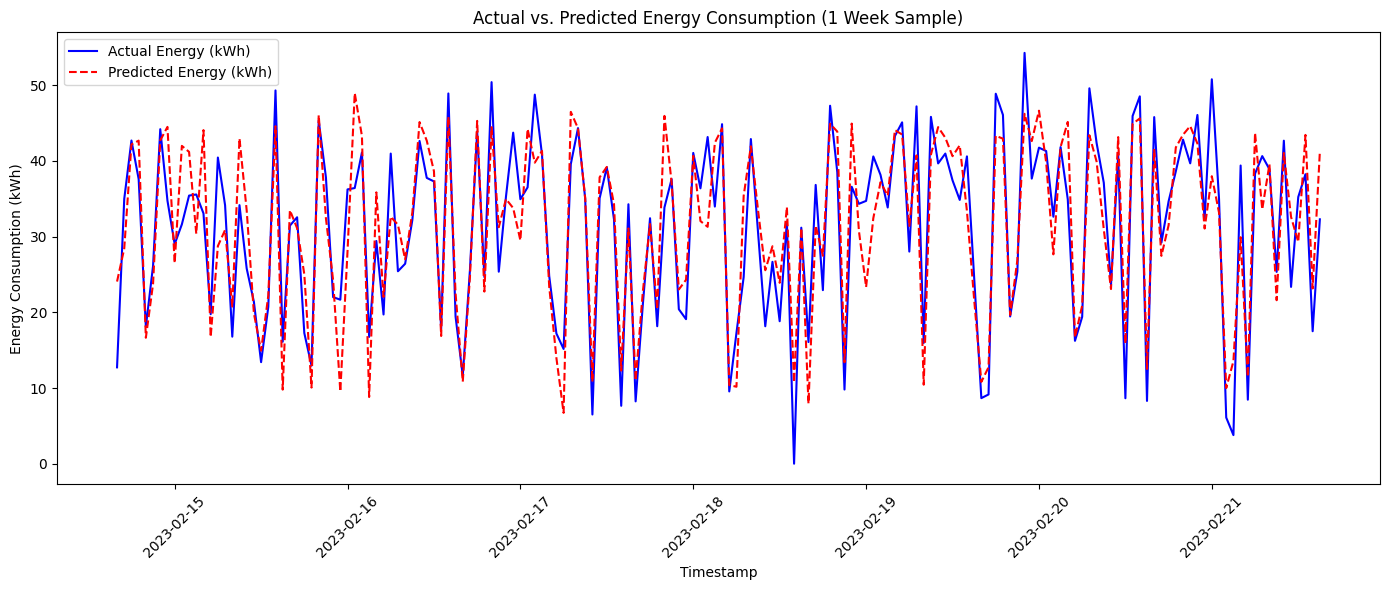

In [31]:
# Assuming 'y_test' (Actual) and 'y_pred_xgb' (Predicted) are defined from Step 2

results_df = pd.DataFrame({
    'Actual Energy': y_test,
    'Predicted Energy': y_pred_xgb
})

# Plot a small, representative sample (e.g., the last 168 hours or 1 week)
plot_sample = results_df.tail(168)

plt.figure(figsize=(14, 6))
plt.plot(plot_sample.index, plot_sample['Actual Energy'], label='Actual Energy (kWh)', color='blue')
plt.plot(plot_sample.index, plot_sample['Predicted Energy'], label='Predicted Energy (kWh)', color='red', linestyle='--')
plt.title('Actual vs. Predicted Energy Consumption (1 Week Sample)')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

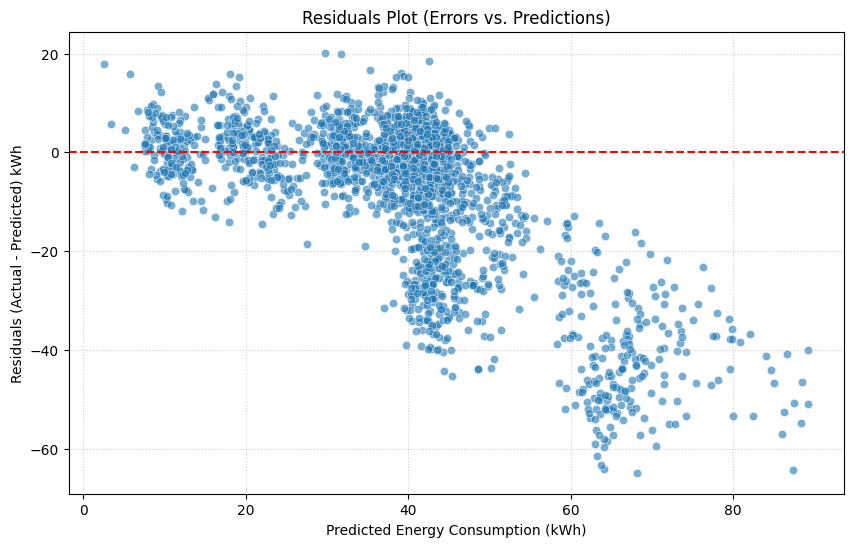

In [32]:
residuals = y_test - y_pred_xgb

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_xgb, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot (Errors vs. Predictions)')
plt.xlabel('Predicted Energy Consumption (kWh)')
plt.ylabel('Residuals (Actual - Predicted) kWh')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [33]:
!pkill -f ngrok
!pkill -f streamlit
!rm -rf /root/.ngrok2
!rm -rf /root/.ngrok
!rm -rf /usr/local/bin/ngrok


In [34]:
!pip install pyngrok --quiet
from pyngrok import ngrok

# Optional — if you have an authtoken from ngrok.com
# ngrok.set_auth_token("YOUR_AUTHTOKEN")


In [35]:
!pip install streamlit pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 128.3 MB/s eta 0:00:00


In [36]:
!ngrok config add-authtoken 33xeCbPWnrBfNO1PCaC83BQArzQ_JUNHFskY29HHY7KtjuqF

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [37]:
import os
print(os.listdir())

['.config', 'saved_models', 'catboost_info', 'cat_model.pkl', 'rf_model.pkl', 'lgbm_model.pkl', 'Energy_consumption_extended.csv', 'sample_data']


✅ Folders created: saved_models/ and saved_models/seq/
✅ Data loaded: (10000, 10)
Encoding categorical columns: ['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']
✅ Split: Train=7999, Test=2000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1589
[LightGBM] [Info] Number of data points in the train set: 7999, number of used features: 12
[LightGBM] [Info] Start training from score 36.316104
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step



✅ MODEL PERFORMANCE SUMMARY:



,MAE,RMSE,MAPE,R2
DNN,5.769,7.935,3176382578.646,0.588
RandomForest,9.612,14.175,5914007685.283,-0.314
LSTM,10.431,12.488,6170179886.902,-0.019
Transformer,10.469,12.420,6031682280.627,-0.008
XGBoost,11.663,17.812,6417830845.596,-1.075
CatBoost,12.369,16.150,5127521645.631,-0.706
LightGBM,14.219,18.265,5221889506.024,-1.182


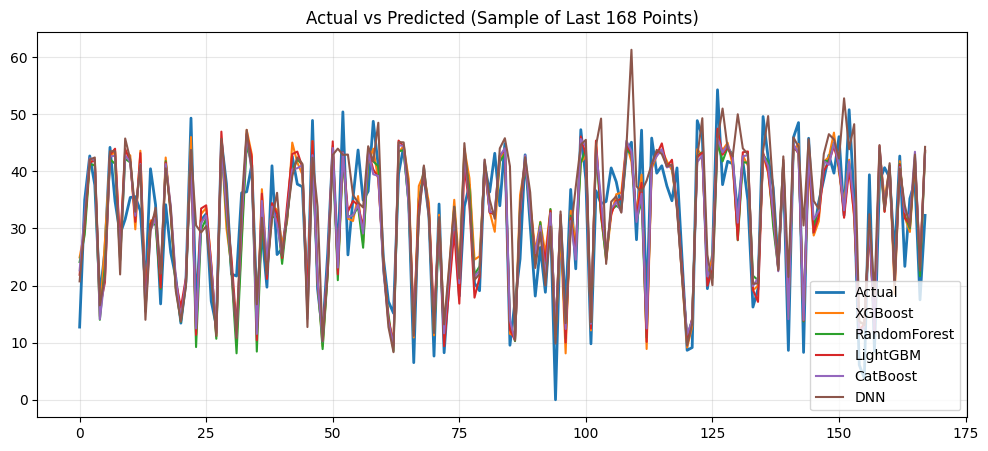

📁 Files in saved_models/: ['cat_model.pkl', 'rf_model.pkl', 'lgbm_model.pkl', 'xgb_model.pkl', 'dnn_model.h5', 'scaler.pkl', 'seq']
📁 Files in saved_models/seq/: ['lstm_model.h5', 'transformer_model.h5']


In [38]:
# =====================================================
# 🧩 HVAC Energy Consumption — Full Model Training
# =====================================================
# ✅ FIXED version: Handles categorical data and saves models
# =====================================================

# -------------------- Imports --------------------
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import matplotlib.pyplot as plt

# -------------------- Folder Setup --------------------
os.makedirs("saved_models/seq", exist_ok=True)
print("✅ Folders created: saved_models/ and saved_models/seq/")

# -------------------- Load Dataset --------------------
DATA_PATH = "Energy_consumption_extended.csv"  # Change path if needed
df = pd.read_csv(DATA_PATH)

# Convert Timestamp column to datetime
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index('Timestamp', inplace=True)

print("✅ Data loaded:", df.shape)
df.head()

# -------------------- Encode Categorical Columns --------------------
# Automatically handle 'On/Off', 'Yes/No', 'Weekday', etc.
cat_cols = df.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    print("Encoding categorical columns:", list(cat_cols))
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
else:
    print("No categorical columns found.")

# -------------------- Feature Engineering --------------------
if 'EnergyConsumption' not in df.columns:
    raise ValueError("❌ Missing target column 'EnergyConsumption' in your dataset.")

df['Hour'] = df.index.hour
df['DayOfYear'] = df.index.dayofyear
df['Energy_Lag1'] = df['EnergyConsumption'].shift(1)
df.dropna(inplace=True)

# -------------------- Define Features --------------------
TARGET_COLUMN = 'EnergyConsumption'
FINAL_FEATURE_COLUMNS = [c for c in df.columns if c != TARGET_COLUMN]

X = df[FINAL_FEATURE_COLUMNS]
y = df[TARGET_COLUMN]

# -------------------- Scale Features --------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=FINAL_FEATURE_COLUMNS, index=X.index)

# -------------------- Sequential Split --------------------
split_ratio = 0.8
split_idx = int(len(X_scaled) * split_ratio)
X_train, X_test = X_scaled.iloc[:split_idx], X_scaled.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"✅ Split: Train={len(X_train)}, Test={len(X_test)}")

# =====================================================
# 📊 Helper Functions
# =====================================================
def evaluate_preds(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

def train_and_eval_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    metrics = evaluate_preds(y_test, preds)
    return model, preds, metrics

# =====================================================
# 🌲 Ensemble & Boosting Models
# =====================================================
models_info = {}

# --- 1. XGBoost ---
xgb_model = xgb.XGBRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=8, random_state=42, n_jobs=-1
)
xgb_model, y_pred_xgb, metrics_xgb = train_and_eval_model(xgb_model, X_train, y_train, X_test, y_test)
models_info["XGBoost"] = {"model": xgb_model, "preds": y_pred_xgb, "metrics": metrics_xgb}
joblib.dump(xgb_model, "saved_models/xgb_model.pkl")

# --- 2. Random Forest ---
rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
rf, rf_preds, rf_metrics = train_and_eval_model(rf, X_train, y_train, X_test, y_test)
models_info["RandomForest"] = {"model": rf, "preds": rf_preds, "metrics": rf_metrics}
joblib.dump(rf, "saved_models/rf_model.pkl")

# --- 3. LightGBM ---
lgbm = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=31, random_state=42)
lgbm, lgbm_preds, lgbm_metrics = train_and_eval_model(lgbm, X_train, y_train, X_test, y_test)
models_info["LightGBM"] = {"model": lgbm, "preds": lgbm_preds, "metrics": lgbm_metrics}
joblib.dump(lgbm, "saved_models/lgbm_model.pkl")

# --- 4. CatBoost ---
cat = CatBoostRegressor(iterations=500, learning_rate=0.03, depth=6, verbose=0, random_seed=42)
cat, cat_preds, cat_metrics = train_and_eval_model(cat, X_train, y_train, X_test, y_test)
models_info["CatBoost"] = {"model": cat, "preds": cat_preds, "metrics": cat_metrics}
joblib.dump(cat, "saved_models/cat_model.pkl")

# =====================================================
# 🧠 Deep Neural Network (DNN)
# =====================================================
def build_dnn(input_shape):
    inp = layers.Input(shape=(input_shape,))
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

dnn = build_dnn(X_train.shape[1])
es = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
dnn.fit(X_train, y_train, validation_split=0.15, epochs=80, batch_size=256, callbacks=[es], verbose=0)

dnn_preds = dnn.predict(X_test).ravel()
dnn_metrics = evaluate_preds(y_test, dnn_preds)
models_info["DNN"] = {"model": dnn, "preds": dnn_preds, "metrics": dnn_metrics}
dnn.save("saved_models/dnn_model.h5")

# =====================================================
# ⏱️ LSTM Sequence Model
# =====================================================
def create_sequences(X_df, y_series, lookback=24):
    X_vals = X_df.values
    y_vals = y_series.values
    n_samples = len(X_vals) - lookback
    X_seq = np.zeros((n_samples, lookback, X_vals.shape[1]))
    y_seq = np.zeros(n_samples)
    for i in range(n_samples):
        X_seq[i] = X_vals[i:i+lookback]
        y_seq[i] = y_vals[i+lookback]
    return X_seq, y_seq

LOOKBACK = 24
X_full = pd.DataFrame(X_scaled, columns=FINAL_FEATURE_COLUMNS, index=X.index)
X_seq, y_seq = create_sequences(X_full, y, LOOKBACK)
split_idx = int(len(X_seq) * 0.8)
X_seq_train, X_seq_test = X_seq[:split_idx], X_seq[split_idx:]
y_seq_train, y_seq_test = y_seq[:split_idx], y_seq[split_idx:]

lstm_in = layers.Input(shape=(LOOKBACK, X_seq_train.shape[2]))
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(lstm_in)
x = layers.Dense(64, activation="relu")(x)
out = layers.Dense(1)(x)
lstm_model = models.Model(lstm_in, out)
lstm_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

es = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lstm_model.fit(X_seq_train, y_seq_train, validation_split=0.1, epochs=50, batch_size=128, callbacks=[es], verbose=0)

lstm_preds = lstm_model.predict(X_seq_test).ravel()
lstm_metrics = evaluate_preds(y_seq_test, lstm_preds)
models_info["LSTM"] = {"model": lstm_model, "preds": lstm_preds, "metrics": lstm_metrics}
lstm_model.save("saved_models/seq/lstm_model.h5")

# =====================================================
# ⚡ Transformer Model
# =====================================================
# =====================================================
# ⚡ Transformer Model (FIXED VERSION)
# =====================================================
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

def transformer_block(inputs, head_size=32, num_heads=2, ff_dim=64):
    # 1️⃣ Multi-head attention (output same shape as input)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = layers.Dense(inputs.shape[-1])(attn_output)  # match dimensions

    # 2️⃣ Residual connection + normalization
    x = layers.Add()([inputs, attn_output])
    x = LayerNormalization()(x)

    # 3️⃣ Feed-forward network
    ff_output = layers.Dense(ff_dim, activation='relu')(x)
    ff_output = layers.Dense(inputs.shape[-1])(ff_output)

    # 4️⃣ Residual connection + normalization
    x = layers.Add()([x, ff_output])
    x = LayerNormalization()(x)
    return x

tr_in = layers.Input(shape=(LOOKBACK, X_seq_train.shape[2]))
x = layers.Dense(64)(tr_in)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(1)(x)
transformer_model = models.Model(tr_in, out)
transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

transformer_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

transformer_model.fit(X_seq_train, y_seq_train, validation_split=0.1, epochs=40, batch_size=128, callbacks=[es], verbose=0)
tr_preds = transformer_model.predict(X_seq_test).ravel()
tr_metrics = evaluate_preds(y_seq_test, tr_preds)
models_info["Transformer"] = {"model": transformer_model, "preds": tr_preds, "metrics": tr_metrics}
transformer_model.save("saved_models/seq/transformer_model.h5")

# =====================================================
# 📈 Model Comparison Summary
# =====================================================
metrics_df = pd.DataFrame({k: v["metrics"] for k, v in models_info.items()}).T
metrics_df = metrics_df[["MAE", "RMSE", "MAPE", "R2"]].sort_values(by="MAE")
print("\n✅ MODEL PERFORMANCE SUMMARY:\n")
display(metrics_df.style.format("{:.3f}"))

# =====================================================
# 🔍 Visualization
# =====================================================
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[-168:], label="Actual", linewidth=2)
for name, info in models_info.items():
    if len(info["preds"]) == len(y_test):
        plt.plot(info["preds"][-168:], label=name)
plt.legend()
plt.title("Actual vs Predicted (Sample of Last 168 Points)")
plt.grid(alpha=0.3)
plt.show()

# =====================================================
# 💾 Verify Saved Files
# =====================================================
print("📁 Files in saved_models/:", os.listdir("saved_models"))
print("📁 Files in saved_models/seq/:", os.listdir("saved_models/seq"))


In [39]:
import os
from pathlib import Path
import joblib
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
# Import standard initializers and activations for custom_objects fix
from tensorflow.keras.initializers import GlorotUniform, Zeros, Ones
from tensorflow.keras.activations import relu, sigmoid

# --- Define the exact feature list your models were trained on ---
# IMPORTANT: This list MUST match the columns used in your training notebook.
EXPECTED_FEATURES = [
    'Temperature', 'Humidity', 'SquareFootage', 'Occupancy',
    'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'DayOfWeek',
    'Holiday', 'Hour', 'DayOfYear', 'Energy_Lag1'
]

st.set_page_config(page_title="Intelligent HVAC Dashboard", layout="wide")
st.title("🌡 Intelligent HVAC Model Comparison Dashboard")

# --- Safe model loaders ---

@st.cache_resource
def load_joblib_if_exists(path):
    p = Path(path)
    if p.exists():
        try:
            # Use joblib.load for models (XGBoost, RF) and scaler
            return joblib.load(str(p))
        except Exception as e:
            st.warning(f"Failed to load {p.name} (Joblib): {e}")
    return None

@st.cache_resource
def load_keras_if_exists(path):
    p = Path(path)
    if p.exists():
        try:
            # --- CRITICAL FIX FOR GlorotUniform/Unknown Initializer ERROR ---
            custom_objects_fix = {
                'GlorotUniform': GlorotUniform,
                'Zeros': Zeros,
                'Ones': Ones,
                'relu': relu,
                'sigmoid': sigmoid,
                # Metrics that might have been saved
                'mse': 'mean_squared_error',
                'mae': 'mean_absolute_error'
            }
            return load_model(str(p), custom_objects=custom_objects_fix)
        except Exception as e:
            st.warning(f"Failed to load Keras model {p.name}: {e}")
            st.error(f"Full Keras Error: {e}")
    return None

# --- Load Data ---
@st.cache_data(ttl=600)
def load_df(path="Energy_consumption_extended.csv"):
    if not Path(path).exists():
        st.error(f"FATAL ERROR: Dataset not found at '{path}'.")
        st.error("Please ensure 'Energy_consumption_extended.csv' is in the same directory.")
        st.stop()
    df = pd.read_csv(path)
    if "Timestamp" in df.columns:
        df["Timestamp"] = pd.to_datetime(df["Timestamp"])
        df = df.set_index("Timestamp")
    # Clean up column names (assuming they match the training data)
    df.columns = [col.replace(' ', '') for col in df.columns]
    return df

try:
    # Assuming your data file is in the same directory as the app
    df = load_df()
except Exception:
    st.stop() # Stop if data loading fails

# --- Load Models & Scaler ---
model_dir = Path("saved_models")
model_dir.mkdir(exist_ok=True) # Create the directory if it doesn't exist

xgb_model = load_joblib_if_exists(model_dir / "xgb_model.pkl")
rf_model  = load_joblib_if_exists(model_dir / "rf_model.pkl")
dnn_model = load_keras_if_exists(model_dir / "dnn_model.h5")
scaler = load_joblib_if_exists(model_dir / "scaler.pkl")

# --- Sidebar Inputs ---
with st.sidebar:
    st.header("1️⃣ Input Parameters")
    outdoor_temp = st.slider("Outdoor Temperature (°C)", -10.0, 50.0, 25.0)
    # Assuming Indoor Temp is not a feature but used for the decision engine
    current_indoor_temp = st.slider("Current Indoor Temp (°C)", 18.0, 30.0, 24.5)
    humidity = st.slider("Humidity (%)", 0, 100, 45)
    occupancy = st.slider("Occupancy (# people)", 0, 200, 10)
    renewable_output = st.slider("Renewable Energy (kW)", 0.0, 100.0, 10.0)
    last_energy = st.number_input("Last Hour Energy (kWh)", min_value=0.0, value=35.0)

    st.markdown("---")
    st.header("2️⃣ Model Comparison")
    available_models = {
        "DNN (Best)": dnn_model,
        "XGBoost": xgb_model,
        "RandomForest": rf_model,
    }
    loaded_models = {name: model for name, model in available_models.items() if model is not None}
    selected_decision_model = st.selectbox(
        "Select Model for HVAC Decision:",
        options=list(loaded_models.keys()),
        index=0 if "DNN (Best)" in loaded_models else 0
    )

    # Used for visualization, keeping the multiselect for comparison plot (if you add it later)
    st.markdown("---")
    st.write("Models available for prediction comparison:")
    for name in loaded_models:
        st.write(f"- {name} Loaded: {'✅' if loaded_models[name] else '❌'}")

# --- 1. Input DataFrame Preparation ---
def prepare_input_df():
    now = pd.to_datetime('now')
    input_dict = {
        # Raw inputs from sliders
        'Temperature': outdoor_temp,
        'Humidity': humidity,
        'Occupancy': occupancy,
        'RenewableEnergy': renewable_output,
        'Energy_Lag1': last_energy,
        # Time-based features
        'Hour': now.hour,
        'DayOfYear': now.dayofyear,
        'DayOfWeek': now.dayofweek,
        'Holiday': 1 if now.dayofweek >= 5 else 0, # Simple weekend check
        # Constant/Mode features (taking mean/mode from the historical data)
        'SquareFootage': df['SquareFootage'].mean(),
        'HVACUsage': df['HVACUsage'].mode()[0] if 'HVACUsage' in df.columns else 'On', # Defaulting to 'On' if not found
        'LightingUsage': df['LightingUsage'].mode()[0] if 'LightingUsage' in df.columns else 'Off'
    }
    # Ensure the dataframe only has the expected features in the correct order
    input_df = pd.DataFrame([input_dict])[EXPECTED_FEATURES]
    return input_df

input_df = prepare_input_df()

# --- 2. Scale Input (Final check before prediction) ---
X_in = None
if scaler:
    try:
        df_to_scale = input_df.copy()

        # Convert categorical 'On'/'Off' columns to numeric (1/0) before scaling
        if 'HVACUsage' in df_to_scale.columns:
             df_to_scale['HVACUsage'] = df_to_scale['HVACUsage'].replace({'On': 1, 'Off': 0}).astype(float)
        if 'LightingUsage' in df_to_scale.columns:
             df_to_scale['LightingUsage'] = df_to_scale['LightingUsage'].replace({'On': 1, 'Off': 0}).astype(float)

        # Scale the prepared, numeric data
        X_in = scaler.transform(df_to_scale)

    except Exception as e:
        st.error(f"Error during scaling: {e}")
        st.warning("Prediction requires all features to be numeric and match the scaler's training shape.")
        st.stop()
else:
    st.error("Scaler (scaler.pkl) not found. Cannot make accurate predictions.")
    st.stop()


# --- 3. Prediction Function (Includes fixes for both shape and index errors) ---
def make_prediction(model_name, model, X_scaled_input):
    if model is None or X_scaled_input is None:
        return np.nan
    try:
        # Default input is 2D: (1, 12)
        input_data = X_scaled_input.reshape(1, -1)

        # Check for Keras/TensorFlow model and adjust shape for sequence models (LSTM, RNN, etc.)
        if isinstance(model, tf.keras.Model):
            # If the model expects a 3D input, we reshape from (1, 12) to (1, 1, 12)
            if len(model.input_shape) == 3:
                input_data = X_scaled_input.reshape(1, 1, -1)

        # Proceed with prediction
        output_array = model.predict(input_data, verbose=0) # suppress Keras output

        # SAFETY CHECK: Ensure the array is NOT empty before indexing (Prevents IndexError)
        if output_array.size == 0:
            st.error(f"Model {model_name} returned an empty prediction array.")
            return np.nan

        prediction = output_array.ravel()[0]
        return max(0, prediction)
    except Exception as e:
        st.error(f"Prediction error for {model_name}: {e}")
        return np.nan

# --- 4. Decision Engine (Rule-Based Control) ---
def make_hvac_decision(predicted_energy, current_indoor_temp):
    # Rule 1: Comfort Override (Too Hot)
    if current_indoor_temp > 25.0:
        return "HVAC ON (A/C Priority - Set to 21°C)", "red", "COMFORT OVERRIDE: Indoor temperature exceeds maximum acceptable setpoint. Immediate cooling required."

    # Rule 2: Comfort Override (Too Cold)
    if current_indoor_temp < 19.0:
         return "Furnace ON (Heating Priority - Set to 22°C)", "blue", "COMFORT OVERRIDE: Indoor temperature is below minimum acceptable setpoint. Immediate heating required."

    # Define High Energy Risk (e.g., predicted load is high relative to the average)
    ENERGY_THRESHOLD = 50.0 # kWh (Assuming 50kWh is a high consumption hour)

    # Rule 3: Smart Energy Optimization
    if predicted_energy > ENERGY_THRESHOLD:
        # Predicted consumption is high, and comfort is okay (25 > T > 19). Turn off or defer.
        return "HVAC OFF, Fan OFF", "orange", f"ENERGY OPTIMIZATION: Predicted load ({predicted_energy:.2f} kWh) is high. Deferring HVAC to minimize peak demand."

    # Rule 4: Conservation Mode
    elif predicted_energy > 0:
        # Predicted consumption is low, but still consuming.
        return "HVAC OFF, Fan ON", "green", "CONSERVATION MODE: Predicted load is acceptable. Use only the fan to maintain air circulation and conserve compressor energy."

    # Default (Low load, mild conditions)
    else:
        return "HVAC OFF (Standby)", "green", "STANDBY: Predicted load is near zero and indoor conditions are stable."

# --- Main Dashboard Logic ---
selected_model = loaded_models.get(selected_decision_model)
prediction_value = make_prediction(selected_decision_model, selected_model, X_in)

# --- Metrics and Command Display ---
st.header("✅ 3. Intelligent Control Output")
col1, col2 = st.columns(2)

with col1:
    st.subheader("Predicted Energy Forecast")

    # --- CRITICAL FIX: Check for NaN and handle gracefully ---
    if np.isnan(prediction_value):
        st.error("Prediction failed for the selected model. Cannot proceed with energy forecast metrics.")
        # Returning here stops this 'with col1:' block from executing further,
        # preventing the StreamlitAPIException on st.progress()
        pass
    else:
        delta = prediction_value - last_energy
        st.metric(
            label=f"Next Hour Energy Forecast ({selected_decision_model})",
            value=f"{prediction_value:.2f} kWh",
            delta=f"{delta:.2f} kWh vs Last Hour"
        )

        # Energy Risk Level (relative to a max load of 100 kWh)
        risk_level = min(prediction_value / 100.0, 1.0)
        risk_text = "HIGH Risk" if risk_level > 0.5 else "LOW Risk"
        st.progress(float(risk_level), text=f"Energy Risk Level ({risk_text})")
    # --- End CRITICAL FIX ---


with col2:
    st.subheader("Optimal HVAC Command")

    # Ensure prediction is valid before making the decision
    if not np.isnan(prediction_value):
        action, color, reason = make_hvac_decision(prediction_value, current_indoor_temp)

        if "ON" in action:
            st.success(f"**Action:** {action}", icon="💡")
        elif "OFF" in action:
            st.info(f"**Action:** {action}", icon="✅")
        else:
            st.warning(f"**Action:** {action}", icon="⚠️")

        st.markdown(f"**Reason:** {reason}")
    else:
        st.warning("Cannot determine optimal HVAC command due to failed energy prediction.")


st.markdown("---")

# --- All Model Comparison Section ---
st.header("📈 4. Real-Time Model Comparison")
comparison_cols = st.columns(len(loaded_models))
all_preds = {}

for i, (name, model) in enumerate(loaded_models.items()):
    # Re-use the robust prediction function
    pred = make_prediction(name, model, X_in)
    all_preds[name] = pred
    comparison_cols[i].metric(
        label=f"Forecast: {name}",
        value=f"{pred:.2f} kWh" if not np.isnan(pred) else "N/A"
    )

# --- Final Input Check ---
st.markdown("---")
st.subheader("Current Calculated Input State (Scaled)")
# Display the scaled data to help debug
st.dataframe(pd.DataFrame(X_in, columns=EXPECTED_FEATURES))


2025-11-12 06:50:47.425 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 06:50:47.428 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 06:50:48.178 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-12 06:50:48.179 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 06:50:48.180 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-12 06:50:48.182 No runtime found, using MemoryCacheStorageManager
2025-11-12 06:50:48.185 No runtime found, using MemoryCacheStorageManager
2025-11-12 06:50:48.186 Thread 'MainThread': missing ScriptRunContext! This warning ca

DeltaGenerator()

In [40]:
!pkill -f ngrok


In [41]:
!pkill -f "ngrok|streamlit" || true
!rm -rf /root/.ngrok2
!rm -rf /root/.ngrok
!pip uninstall -y pyngrok
!pip install pyngrok --quiet

^C
Found existing installation: pyngrok 7.4.1
Uninstalling pyngrok-7.4.1:
  Successfully uninstalled pyngrok-7.4.1


In [42]:
!ls kill

ls: cannot access 'kill': No such file or directory


In [43]:
!pkill -f ngrok
!pkill -f streamlit
!rm -rf /root/.ngrok2
!rm -rf /root/.ngrok


In [44]:
!pip uninstall -y pyngrok
!pip install pyngrok --quiet


Found existing installation: pyngrok 7.4.1
Uninstalling pyngrok-7.4.1:
  Successfully uninstalled pyngrok-7.4.1


In [45]:
from pyngrok import ngrok
ngrok.set_auth_token("33gttL9LdtjIgB32vbF5hdcPLrC_3uMebwNqdY3Cg54kv9J9J")


In [46]:
import os, time
from pyngrok import ngrok

# 1. Kill any leftover tunnels
print("🧹 Clearing old processes...")
os.system("pkill -f streamlit >/dev/null 2>&1 || true")
os.system("pkill -f ngrok >/dev/null 2>&1 || true")
try:
    ngrok.kill()
except:
    pass

time.sleep(3)

# 2. Launch Streamlit in background with the correct flags
print("🚀 Starting Streamlit app...")

# --- THIS IS THE MODIFIED LINE ---
# The corrected command with the necessary flags
os.system("nohup streamlit run hvac_app_extended.py --server.port 8501 --server.headless=true --server.enableCORS=false &")

# 3. Wait for app to load
time.sleep(8)

# 4. Start ngrok tunnel
print("🌍 Creating fresh ngrok tunnel...")
try:
    tunnel = ngrok.connect(8501)
    public_url = tunnel.public_url
    print(f"\n✅ Streamlit app is live at:\n👉 {public_url}")
except Exception as e:
    print(f"❌ Failed to create ngrok tunnel: {e}")

🧹 Clearing old processes...
🚀 Starting Streamlit app...
🌍 Creating fresh ngrok tunnel...

✅ Streamlit app is live at:
👉 https://bulgy-wendy-undappled.ngrok-free.dev
